In [1]:
########################################################
# STEP 0 - Import necessary files and define functions
########################################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import math
import json

# Import questions into dataframe
dTypes = {'Language': object, 'Library': object, 'Unnamed: 0': object, 'Id': object, 'PostTypeId': object, 'AcceptedAnswerId': object, 'CreationDate': object, 'Score': object, 'ViewCount': object, 'Body': object, 'LastEditDate': object, 'LastActivityDate': object, 'Title': object, 'Tags': object, 'AnswerCount': object, 'ClosedDate': object}
dateCols = ['CreationDate', 'LastEditDate', 'LastActivityDate', 'ClosedDate']
QuestionLibs = pd.read_csv('SO_BDA_Q_Libraries_in_Skill_Space.csv', dtype=dTypes, parse_dates=dateCols)

QuestionLibs = QuestionLibs[~QuestionLibs.ViewCount.str.contains("-", na=False)]
QuestionLibs = QuestionLibs[~QuestionLibs.PostTypeId.str.contains("-", na=False)]
QuestionLibs = QuestionLibs[~QuestionLibs["Unnamed: 0"].str.contains("-", na=False)]
QuestionLibs = QuestionLibs[~QuestionLibs["Id"].str.contains("-", na=False)]
QuestionLibs = QuestionLibs[~QuestionLibs["AcceptedAnswerId"].str.contains("-", na=False)]
QuestionLibs = QuestionLibs[~QuestionLibs["Score"].str.contains("-", na=False)]
QuestionLibs = QuestionLibs[~QuestionLibs["AnswerCount"].str.contains("-", na=False)]

# Reformat numeric and datetime columns correctly 
QuestionLibs["Unnamed: 0"] = pd.to_numeric(QuestionLibs["Unnamed: 0"])
QuestionLibs["Unnamed: 0.1"] = pd.to_numeric(QuestionLibs["Unnamed: 0.1"])
QuestionLibs["Id"] = pd.to_numeric(QuestionLibs["Id"])
QuestionLibs["PostTypeId"] = pd.to_numeric(QuestionLibs["PostTypeId"])
QuestionLibs["AcceptedAnswerId"] = pd.to_numeric(QuestionLibs["AcceptedAnswerId"])
QuestionLibs["CreationDate"] = pd.to_datetime(QuestionLibs["CreationDate"])
QuestionLibs["Score"] = pd.to_numeric(QuestionLibs["Score"])
QuestionLibs["ViewCount"] = pd.to_numeric(QuestionLibs["ViewCount"])
QuestionLibs["LastEditDate"] = pd.to_datetime(QuestionLibs["LastEditDate"])
QuestionLibs["LastActivityDate"] = pd.to_datetime(QuestionLibs["LastActivityDate"])
QuestionLibs["AnswerCount"] = pd.to_numeric(QuestionLibs["AnswerCount"])
QuestionLibs["ClosedDate"] = pd.to_datetime(QuestionLibs["ClosedDate"])

QuestionLibs = QuestionLibs[~QuestionLibs["CreationDate"].isna()]

# Import answers into dataframe
dTypes = {'Language': object, 'Library': object, 'Unnamed: 0': object, 'Id': object, 'PostTypeId': object, 'ParentId': object, 'CreationDate': object, 'Score': object, 'ViewCount': object, 'Body': object, 'LastEditDate': object, 'LastActivityDate': object, 'CommentCount': object}
dateCols = ['CreationDate', 'LastEditDate', 'LastActivityDate']
AnswerLibs = pd.read_csv('SO_BDA_A_Libraries_in_Skill_Space.csv', dtype=dTypes, parse_dates=dateCols)

AnswerLibs = AnswerLibs[~AnswerLibs.ViewCount.str.contains("-", na=False)]
AnswerLibs = AnswerLibs[~AnswerLibs.PostTypeId.str.contains("-", na=False)]
AnswerLibs = AnswerLibs[~AnswerLibs["Unnamed: 0"].str.contains("-", na=False)]
# AnswerLibs = AnswerLibs[~AnswerLibs["Unnamed: 0.1"].str.contains("-", na=False)]
AnswerLibs = AnswerLibs[~AnswerLibs["Id"].str.contains("-", na=False)]
AnswerLibs = AnswerLibs[~AnswerLibs["ParentId"].str.contains("-", na=False)]
AnswerLibs = AnswerLibs[~AnswerLibs["Score"].str.contains("-", na=False)]
AnswerLibs = AnswerLibs[~AnswerLibs["CommentCount"].str.contains("-", na=False)]

AnswerLibs = AnswerLibs[~AnswerLibs["CreationDate"].isna()]

# Reformat numeric and datetime columns correctly 
AnswerLibs["Unnamed: 0"] = pd.to_numeric(AnswerLibs["Unnamed: 0"])
AnswerLibs["Unnamed: 0.1"] = pd.to_numeric(AnswerLibs["Unnamed: 0.1"])
AnswerLibs["Id"] = pd.to_numeric(AnswerLibs["Id"])
AnswerLibs["PostTypeId"] = pd.to_numeric(AnswerLibs["PostTypeId"])
AnswerLibs["ParentId"] = pd.to_numeric(AnswerLibs["ParentId"])
AnswerLibs["CreationDate"] = pd.to_datetime(AnswerLibs["CreationDate"])
AnswerLibs["Score"] = pd.to_numeric(AnswerLibs["Score"])
AnswerLibs["ViewCount"] = pd.to_numeric(AnswerLibs["ViewCount"])
AnswerLibs["LastEditDate"] = pd.to_datetime(AnswerLibs["LastEditDate"])
AnswerLibs["LastActivityDate"] = pd.to_datetime(AnswerLibs["LastActivityDate"])
AnswerLibs["CommentCount"] = pd.to_numeric(AnswerLibs["CommentCount"])

QuestionLibs["AnswerCount"] = QuestionLibs["AnswerCount"].replace(0.0, np.nan)
AnswerLibs["CommentCount"] = AnswerLibs["CommentCount"].replace(0.0, np.nan)

In [2]:
########################################################
# STEP 1 - Import cluster names and define metric df's
########################################################

with open('clusters.json') as json_file:
    clusters_set = json.load(json_file)

clusts = clusters_set.keys()

metrics = ["AcceptedAnswersPercentage", "AnswerCountMean", "CommentCountMean", "QuestionBodySizeMean", "AnswerBodySizeMean", "QuestionRevisionsPercentage", "AnswerRevisionsPercentage", "TagCountMean", "ScoreMean", "ViewCountMean"]

difficultyDF = pd.DataFrame(columns = metrics, index = clusts)

QuestionLibs["Cluster"] = np.nan
AnswerLibs["Cluster"] = np.nan

for name in clusts:
    QuestionLibs.loc[QuestionLibs['Library'].isin(clusters_set[name]), 'Cluster'] = name
    AnswerLibs.loc[AnswerLibs['Library'].isin(clusters_set[name]), 'Cluster'] = name

QuestionLibs = QuestionLibs.sort_values(by='CreationDate')
AnswerLibs = AnswerLibs.sort_values(by='CreationDate')

In [3]:
########################################################
# STEP 2 - Calculate all difficulty metrics
########################################################

# AcceptedAnswersPercentage
    # Percentage of questions that have an accepted answer 
difficultyDF['AcceptedAnswersPercentage'] = (QuestionLibs.groupby(['Cluster', 'Library'])["AcceptedAnswerId"].count() / ( QuestionLibs.groupby(['Cluster', 'Library'])["AcceptedAnswerId"].count() + QuestionLibs.groupby(['Cluster', 'Library'])["AcceptedAnswerId"].apply(lambda x: x.isnull().sum()) )).groupby('Cluster').mean().to_frame()


# AnswerCountMean
    # Average number of answers per question on posts involving libraries in that cluster
difficultyDF['AnswerCountMean'] = (QuestionLibs.groupby(['Cluster', 'Library'])["AnswerCount"].sum() / QuestionLibs.groupby(['Cluster', 'Library'])["AnswerCount"].count()).groupby('Cluster').mean().to_frame()

# CommentCountMean
    # Average number of comments per answer on posts involving libraries in that cluster
difficultyDF['CommentCountMean'] = (AnswerLibs.groupby(['Cluster', 'Library'])["CommentCount"].sum() / AnswerLibs.groupby(['Cluster', 'Library'])["CommentCount"].count()).groupby('Cluster').mean().to_frame()

# QuestionBodySizeMean
    # Number of characters in questions being asked about libraries in that cluster
difficultyDF['QuestionBodySizeMean'] = QuestionLibs.groupby(['Cluster', 'Library'])["Body"].apply(lambda x: np.mean(x.str.len())).groupby('Cluster').mean().to_frame()

# AnswerBodySizeMean
    # Number of characters in answers being asked about libraries in that cluster
difficultyDF['AnswerBodySizeMean'] = AnswerLibs.groupby(['Cluster', 'Library'])["Body"].apply(lambda x: np.mean(x.str.len())).groupby('Cluster').mean().to_frame()

# QuestionRevisionsPercentage
    # Percentage of questions that have a LastEditDate per cluster
difficultyDF['QuestionRevisionsPercentage'] = (QuestionLibs.groupby(['Cluster', 'Library'])["LastEditDate"].count() / ( QuestionLibs.groupby(['Cluster', 'Library'])["LastEditDate"].count() + QuestionLibs.groupby(['Cluster', 'Library'])["LastEditDate"].apply(lambda x: x.isnull().sum()) )).groupby('Cluster').mean().to_frame()

# AnswerRevisionsPercentage
    # Percentage of answers that have a LastEditDate per cluster
difficultyDF['AnswerRevisionsPercentage'] = (AnswerLibs.groupby(['Cluster', 'Library'])["LastEditDate"].count() / ( AnswerLibs.groupby(['Cluster', 'Library'])["LastEditDate"].count() + AnswerLibs.groupby(['Cluster', 'Library'])["LastEditDate"].apply(lambda x: x.isnull().sum()) )).groupby('Cluster').mean().to_frame()

# TagCountMean
    # Average number of tags per question per cluster
difficultyDF['TagCountMean'] = QuestionLibs.groupby(['Cluster', 'Library'])["Tags"].apply(lambda x: np.mean(x.str.count('<'))).groupby('Cluster').mean()

# ScoreMean
    # Average score of questions per cluster
difficultyDF['ScoreMean'] = QuestionLibs.groupby(['Cluster', 'Library'])["Score"].mean().groupby('Cluster').mean()

# ViewCountMean        
    # Average number of answers viewed for every question viewed per cluster
difficultyDF['ViewCountMean'] = AnswerLibs.groupby(['Cluster', 'Library'])["ViewCount"].mean().groupby('Cluster').mean() / QuestionLibs.groupby(['Cluster', 'Library'])["ViewCount"].mean().groupby('Cluster').mean() 
   

FileNotFoundError: [Errno 2] No such file or directory: 'RQ2 - Graphs/AcceptedAnswersPercentage.png'

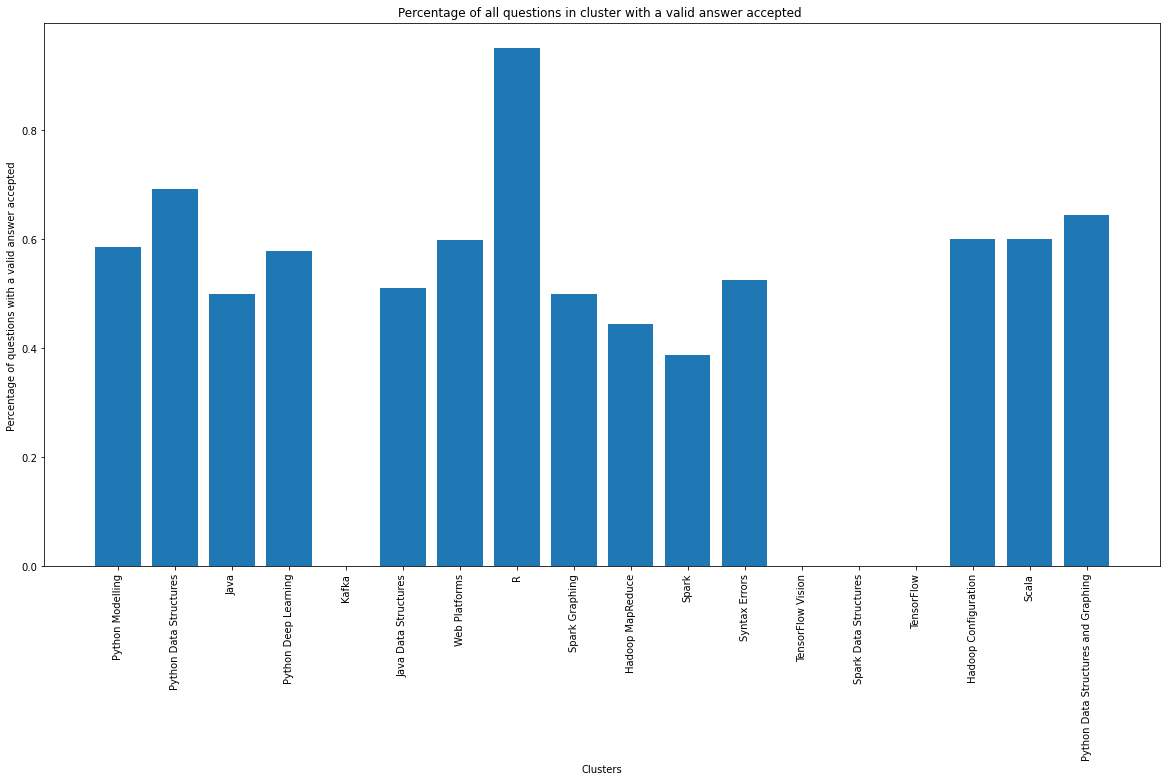

In [4]:
########################################################
# STEP 3 - Graph all metrics 
########################################################

# AcceptedAnswersPercentage
    # Percentage of all questions in cluster with a valid answer accepted 
x_axis = difficultyDF.index.tolist()
y_axis = difficultyDF["AcceptedAnswersPercentage"].tolist()
plt.figure(figsize=(20,10))
plt.bar(x_axis, y_axis)
plt.xlabel('Clusters')
plt.ylabel('Percentage of questions with a valid answer accepted ')
plt.title('Percentage of all questions in cluster with a valid answer accepted ')
plt.xticks(rotation=90)
plt.savefig('RQ2 - Graphs/AcceptedAnswersPercentage.png')
plt.show()

# AnswerCountMean
    # Average number of answers per question on posts involving libraries in that cluster
x_axis = difficultyDF.index.tolist()
y_axis = difficultyDF["AnswerCountMean"].tolist()
plt.figure(figsize=(20,10))
plt.bar(x_axis, y_axis)
plt.xlabel('Clusters')
plt.ylabel('Average number of answers per question')
plt.title('Average number of answers per question per cluster')
plt.xticks(rotation=90)
plt.savefig('RQ2 - Graphs/AnswerCountMean.png')
plt.show()

# CommentCountMean
    # Average number of comments per answer on posts involving libraries in that cluster
x_axis = difficultyDF.index.tolist()
y_axis = difficultyDF["CommentCountMean"].tolist()
plt.figure(figsize=(20,10))
plt.bar(x_axis, y_axis)
plt.xlabel('Clusters')
plt.ylabel('Average number of comments per answer')
plt.title('Average number of comments per answer per cluster')
plt.xticks(rotation=90)
plt.savefig('RQ2 - Graphs/CommentCountMean.png')
plt.show()

# QuestionBodySizeMean
    # Number of characters in questions being asked about libraries in that cluster
x_axis = difficultyDF.index.tolist()
y_axis = difficultyDF["QuestionBodySizeMean"].tolist()
plt.figure(figsize=(20,10))
plt.bar(x_axis, y_axis)
plt.xlabel('Clusters')
plt.ylabel('Average number of characters in questions')
plt.title('Average number of characters in questions per cluster')
plt.xticks(rotation=90)
plt.savefig('RQ2 - Graphs/QuestionBodySizeMean.png')
plt.show()

# AnswerBodySizeMean
    # Number of characters in answers being asked about libraries in that cluster
x_axis = difficultyDF.index.tolist()
y_axis = difficultyDF["AnswerBodySizeMean"].tolist()
plt.figure(figsize=(20,10))
plt.bar(x_axis, y_axis)
plt.xlabel('Clusters')
plt.ylabel('Average number of characters in answers')
plt.title('Average number of characters in answers per cluster')
plt.xticks(rotation=90)
plt.savefig('RQ2 - Graphs/AnswerBodySizeMean.png')
plt.show()

# QuestionRevisionsPercentage
    # Percentage of questions that have a LastEditDate per cluster
x_axis = difficultyDF.index.tolist()
y_axis = difficultyDF["QuestionRevisionsPercentage"].tolist()
plt.figure(figsize=(20,10))
plt.bar(x_axis, y_axis)
plt.xlabel('Clusters')
plt.ylabel('Average percentage of questions that have been edited since posting')
plt.title('Average percentage of questions that have been edited since posting per cluster')
plt.xticks(rotation=90)
plt.savefig('RQ2 - Graphs/QuestionRevisionsPercentage.png')
plt.show()

# AnswerRevisionsPercentage
    # Percentage of answers that have a LastEditDate per cluster
x_axis = difficultyDF.index.tolist()
y_axis = difficultyDF["AnswerRevisionsPercentage"].tolist()
plt.figure(figsize=(20,10))
plt.bar(x_axis, y_axis)
plt.xlabel('Clusters')
plt.ylabel('Average percentage of answers that have been edited since posting')
plt.title('Average percentage of answers that have been edited since posting per cluster')
plt.xticks(rotation=90)
plt.savefig('RQ2 - Graphs/AnswerRevisionsPercentage.png')
plt.show()
    
# TagCountMean
    # Average number of tags per question per cluster
x_axis = difficultyDF.index.tolist()
y_axis = difficultyDF["TagCountMean"].tolist()
plt.figure(figsize=(20,10))
plt.bar(x_axis, y_axis)
plt.xlabel('Clusters')
plt.ylabel('Average number of tags per question')
plt.title('Average number of tags per question per cluster')
plt.xticks(rotation=90)
plt.savefig('RQ2 - Graphs/TagCountMean.png')
plt.show()

# ScoreMean
    # Average score of questions per cluster
x_axis = difficultyDF.index.tolist()
y_axis = difficultyDF["ScoreMean"].tolist()
plt.figure(figsize=(20,10))
plt.bar(x_axis, y_axis)
plt.xlabel('Clusters')
plt.ylabel('Average score of questions')
plt.title('Average score of questions per cluster')
plt.xticks(rotation=90)
plt.savefig('RQ2 - Graphs/ScoreMean.png')
plt.show()

# ViewCountMean        
    # Average ViewCount per question per cluster
x_axis = difficultyDF.index.tolist()
y_axis = difficultyDF["ViewCountMean"].tolist()
plt.figure(figsize=(20,10))
plt.bar(x_axis, y_axis)
plt.xlabel('Clusters')
plt.ylabel('Average ViewCount per question')
plt.title('Average ViewCount per question per cluster')
plt.xticks(rotation=90)
plt.savefig('RQ2 - Graphs/ViewCountMean.png')
plt.show()